# Photometric Redshifts with Neural Nets
Stephen Portillo

Based on code for [Figure 9.18](http://www.astroml.org/book_figures/chapter9/fig_photoz_nn.html) of _Statistics, Data Mining, and Machine Learning in Astronomy_ (2020) by Ivezić, Connolly, Vanderplas, and Gray

Be sure to install the required packages:
```
conda install astroml
conda install pytorch
```

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torchdata

from astroML.datasets import fetch_sdss_specgals

In [2]:
# make the plots look nice
mpl.rcParams['figure.dpi'] = 300
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rc('legend', fontsize='x-small')

`astroML` gives us easy access to a [sample of the SDSS galaxies](https://www.astroml.org/modules/generated/astroML.datasets.fetch_sdss_specgals.html): over 600,000 of them! We have a lot of different measurements (features) for each of them, some of them from imaging, others from spectroscopy:

In [3]:
# Fetch and prepare the data
data = fetch_sdss_specgals()
print(data.shape)
print(data.dtype.names)

(661598,)
('ra', 'dec', 'mjd', 'plate', 'fiberID', 'z', 'zErr', 'rChi2', 'velDisp', 'velDispErr', 'extinction_r', 'petroMag_r', 'psfMag_r', 'psfMagErr_r', 'modelMag_u', 'modelMagErr_u', 'modelMag_g', 'modelMagErr_g', 'modelMag_r', 'modelMagErr_r', 'modelMag_i', 'modelMagErr_i', 'modelMag_z', 'modelMagErr_z', 'petroR50_r', 'petroR90_r', 'nii_6584_flux', 'nii_6584_flux_err', 'h_alpha_flux', 'h_alpha_flux_err', 'oiii_5007_flux', 'oiii_5007_flux_err', 'h_beta_flux', 'h_beta_flux_err', 'h_delta_flux', 'h_delta_flux_err', 'd4000', 'd4000_err', 'bptclass', 'lgm_tot_p50', 'sfr_tot_p50', 'objID', 'specObjID')


We are most interested in the (model-fitting) photometry `modelMag` in _u_, _g_, _r_, _i_, and _z_ bands and the spectroscopic redshifts `z`. Let's make another corner plot.

(This cell may take a while to run, since it is plotting over 600,000 points in each of 15 subplots.)

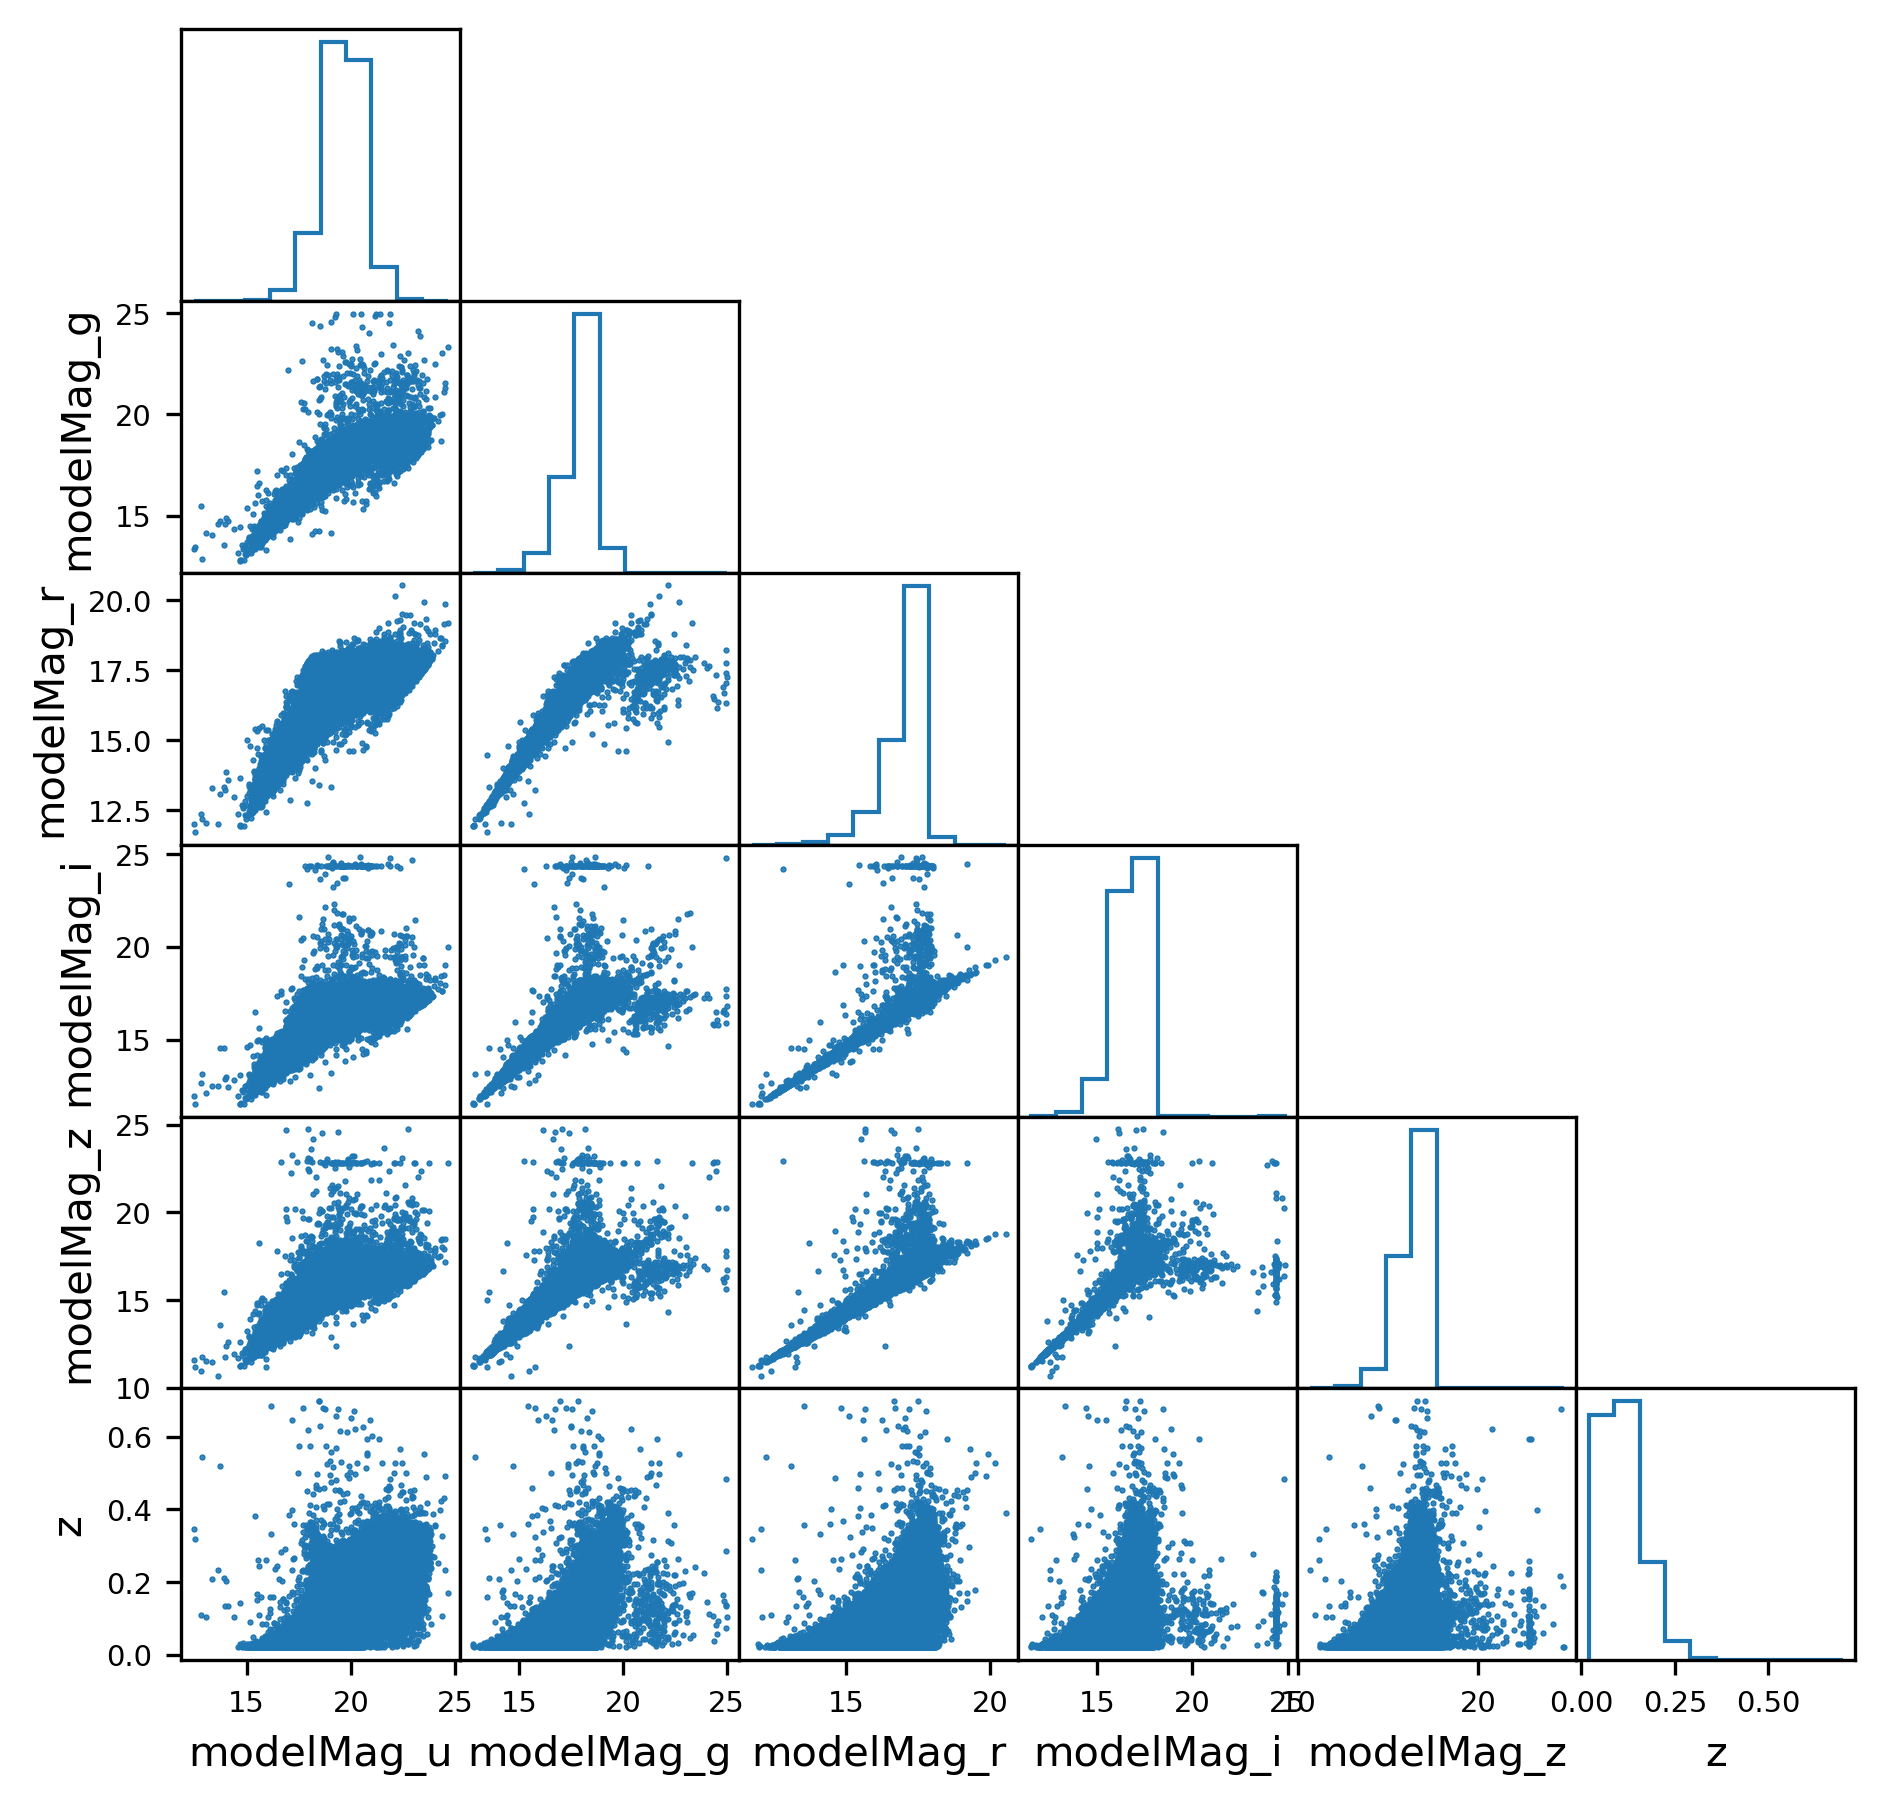

In [4]:
# make a corner plot
features = ['modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z', 'z']

fig = plt.figure(figsize=(7.2,7.2))
fig.subplots_adjust(hspace=0, wspace=0)
# loop through every possible pair of features
for i in range(6):
    for j in range(6):
        # only make subplots in the lower diagonal
        if i <= j:
            plt.subplot(6,6,i+j*6+1)
            # if this subplot is on the left side (but not the top), make a y label
            if i == 0 and j != 0:
                plt.ylabel(features[j])
            # if this subplot is on the bottom, make an x label
            if j == 5:
                plt.xlabel(features[i])
            # remove ticks on interior plots
            if i != 0:
                plt.yticks([])
            if j != 5:
                plt.xticks([])
            # scatter plots in off diagonals
            if i < j:
                plt.scatter(data[features[i]], data[features[j]], s=1, marker='.')
            # histograms on diagonals
            if i == j:
                plt.hist(data[features[i]], histtype='step')
                plt.yticks([]) # don't want counts in the y-axis
plt.show()

While photometry and redshift are definitely related, the relationships seem fairly complicated. We might think about using colors rather than just magnitudes (this would be **feature engineering**), but let's see how well a neural network can do with the raw magnitudes.

One common trick to getting a neural network to train well is to normalize the data. Neural nets are happy when all of the features are of the same scale, and ideally have zero mean and unit standard deviation. Tricks like these make machine learning more of an art than an exact science - knowing *what* to do to make your neural network better can be hard, but *evaluating* your choice is easy - run on the validation set!

In [5]:
# put magnitudes into array
# normalize to zero mean and unit variance for easier training
datanormed = np.zeros((len(data), 6), dtype=np.float32)
for i, band in enumerate(['u', 'g', 'r', 'i', 'z']):
    band = 'modelMag_' + band
    datanormed[:, i] = (data[band] - data[band].mean()) / data[band].std()

# put redshifts into array
datanormed[:, 5] = data['z']

We will use [PyTorch](https://pytorch.org/) to train our neural networks; another popular package is [Keras](https://keras.io/). In PyTorch, we have to write out more of the steps explicitly, which allows more flexibility, whereas Keras code is often much shorter, as long as you're using standard neural network architectures. I learned PyTorch first, which is why we're using it here.

This first cell of code defines our neural network **architecture**. Note that we let the **width** of the hidden layer be a hyperparameter, rather than setting it to be 4.
![Simple Neural Network](http://www.astroml.org/_images/fig_neural_network_1.png)
*Statistics, Data Mining, and Machine Learning in Astronomy* (2020)

*(Super nitpick: there is no activation function $g$ on the output layer in our code because we do not wish to restrict the range of possible output redshifts - nearby galaxies coming towards us could have negative redshift.)*

In [6]:
# define structure of neural net
class Net(nn.Module):
    def __init__(self, nhidden):
        super(Net, self).__init__()
        self.hidden = nn.Linear(5, nhidden)
        self.output = nn.Linear(nhidden, 1)

    def forward(self, x):
        h = F.relu(self.hidden(x))
        z = self.output(h)
        return z

Then we have to set up the dataset to work with PyTorch:

In [7]:
# make a TensorDataset with the photometry as features, redshift as target
dataset = torchdata.TensorDataset(torch.tensor(datanormed[:, 0:5]),
                                  torch.tensor(datanormed[:, 5]).view(-1, 1))
# round 90% of the data set to an integer
trainnum = datanormed.shape[0] // 10 * 9
# split the data into 90% training, 10% validation
torch.manual_seed(0)
traindata, validdata = torchdata.random_split(dataset, [trainnum, datanormed.shape[0] - trainnum])
# make a DataLoader to make minibatches for the training data
traindataloader = torchdata.DataLoader(traindata, batch_size=128, shuffle=True)

And finally, we train the model with PyTorch. There's a lot going on in this cell, and I've written it as a function so that you can easily use it to conduct a hyperparameter search over the hidden layer width or learning rate. All of the choices we made could be hyperparameters, like:
* number of layers
* activation function
* loss function
* optimizer
* scheduler
* early stopping criterion
* mini-batch size (which is in the cell above!)

Knowing what hyperparameters to focus on with limited computer time is part of the art of machine learning.

After initializing the neural network, we specify the **loss function**. Here we use the mean squared error - the mean is taken over dimensions of the target, but since our target is only 1D (redshift), this is just the squared error in the predicted redshift. (`reduction=sum` means that the loss function is the sum of the squared error for each galaxy - this is convenient when we divide the data into mini-batches: we can add the loss functions together without worrying about how many galaxies are in each minibatch)

We then set up the Stochastic Gradient Descent (SGD) **optimizer**, with the specified **learning rate**. The SGD optimizer will expect data to be fed in mini-batches - calculating the gradient separately on each mini-batch introduces stochasticity. When all of the data have been fed through once, one **epoch** has passed, and the data will be fed in anew next epoch.

We will also use a **scheduler** that reduces the learning rate when the validation loss stops improving for 5 epochs.

We write a for loop that will proceed for a maximum of 100 epochs. In each epoch, we first feed the training data, in mini-batches, into the network. We calculate the loss on each mini-batch, and then do **backpropagation** to calculate the gradient of the loss function with respect to every free parameter (weights and biases) in the neural network). The optimizer then uses these gradients to take a step: to change the parameters slightly.

We then run the partially-trained network on the validation set to see how it's doing. Importantly, we do *not* change the network based on the validation set - the `with torch.no_grad()` statement ensures this.

After printing the training and validation root mean squared error, we decide whether to use **early stopping** and stop training: we stop training if the validation loss has not improved in 10 epochs.

Finally, we give the validation loss to the scheduler - the scheduler will reduce the learning rate if the validation loss has not improved in 5 epochs.

In [8]:
def trainmodel(nhidden=4, lr=0.001):
    # initialize the neural net
    model = Net(nhidden)
    # use the MSE loss function
    criterion = torch.nn.MSELoss(reduction='sum')
    # use the SGD optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    # use a scheduler that reduces the learning rate by 10x when the validation loss stalls for 5 epochs
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5, threshold=1e-3)

    # count how many epochs the validation loss has stopped for
    min_valid_loss = float('inf')
    badepochs = 0

    nepoch = 100
    train_RMSE = np.zeros(nepoch)
    valid_RMSE = np.zeros(nepoch)

    # for each epoch
    for t in range(nepoch):
        train_loss = 0
        # go through each minibatch of the training data
        for i, databatch in enumerate(traindataloader, 0):
            photometry, redshifts = databatch # unpack the minibatch
            optimizer.zero_grad() # clear the gradient calculation
            z_pred = model(photometry) # feed the training data in
            loss = criterion(z_pred, redshifts) # calculate the loss function
            loss.backward() # take the gradients of the loss function
            optimizer.step() # use these gradients to take a step
            train_loss += loss.item() # accumulate the training loss
        
        # calculate the RMSE on the training set this epoch
        train_RMSE[t] = np.sqrt(train_loss / len(traindata))

        # disable the calculation of gradients while we work with the validation set
        with torch.no_grad():
            # unpack the validation set
            photometry = validdata[:][0] 
            redshifts = validdata[:][1]
            # feed the validation data in
            z_pred = model(photometry)
            # calculate the loss function
            valid_loss = criterion(z_pred, redshifts)
            # calculate the RMSE on the validation set for this epoch
            valid_RMSE[t] = np.sqrt(valid_loss / len(validdata))

            # print the training and validation RMSEs
            print('Epoch %3i: training RMSE %0.5f validation RMSE %0.5f' % \
                  (t, train_RMSE[t], valid_RMSE[t]))

            # if the validation loss hasn't gone down, add one to the counter
            if valid_loss > min_valid_loss*(1-1e-3):
                badepochs += 1
            # if the validation loss HAS gone down, reset the counter
            else:
                min_valid_loss = valid_loss
                badepochs = 0
            
            # if the validation loss has stalled for 10 epochs, stop training
            if badepochs == 10:
                print('Finished training')
                break
                
        # use the validation loss to decide whether to decrease the learning rate
        scheduler.step(valid_loss)
    
    # return the trained model, and the training and validation RMSE histories
    return model, train_RMSE[:t+1], valid_RMSE[:t+1]

Now it's time to train the model! First, we'll use the default hyperparameters: a hidden layer width of 4 and learning rate of 0.001. Training takes much longer than for the decision trees: on DIRAC's computer, the training cell takes 3 minutes on one thread to run 50 epochs.

![xkcd: Compiling](https://imgs.xkcd.com/comics/compiling.png "'Are you stealing those LCDs?' 'Yeah, but I'm doing it while my code compiles.'")
CC BY-NC 2.5 [https://xkcd.com/303]

*OK, we're training a model, not compiling code, but the comic still applies...*

In [9]:
# I'm running this on a server that many other people use, so I only want to use one thread
# If you're running this on your own computer, try commenting this line out to see if it goes faster!
torch.set_num_threads(1)

In [10]:
%%time
model, train_RMSE, valid_RMSE = trainmodel()

Epoch   0: training RMSE 0.03551 validation RMSE 0.03033
Epoch   1: training RMSE 0.03045 validation RMSE 0.02976
Epoch   2: training RMSE 0.03007 validation RMSE 0.02954
Epoch   3: training RMSE 0.02989 validation RMSE 0.02937
Epoch   4: training RMSE 0.02970 validation RMSE 0.02921
Epoch   5: training RMSE 0.02943 validation RMSE 0.02895
Epoch   6: training RMSE 0.02902 validation RMSE 0.02854
Epoch   7: training RMSE 0.02848 validation RMSE 0.02788
Epoch   8: training RMSE 0.02683 validation RMSE 0.02600
Epoch   9: training RMSE 0.02577 validation RMSE 0.02533
Epoch  10: training RMSE 0.02530 validation RMSE 0.02510
Epoch  11: training RMSE 0.02505 validation RMSE 0.02486
Epoch  12: training RMSE 0.02487 validation RMSE 0.02479
Epoch  13: training RMSE 0.02471 validation RMSE 0.02461
Epoch  14: training RMSE 0.02458 validation RMSE 0.02476
Epoch  15: training RMSE 0.02448 validation RMSE 0.02444
Epoch  16: training RMSE 0.02440 validation RMSE 0.02443
Epoch  17: training RMSE 0.0243

If we look at the training and validation errors, we can see that a little bit of overfitting is occuring at late epochs: the validation loss is slightly above the training loss. This is expected, and it's a good sign that the two losses are close.

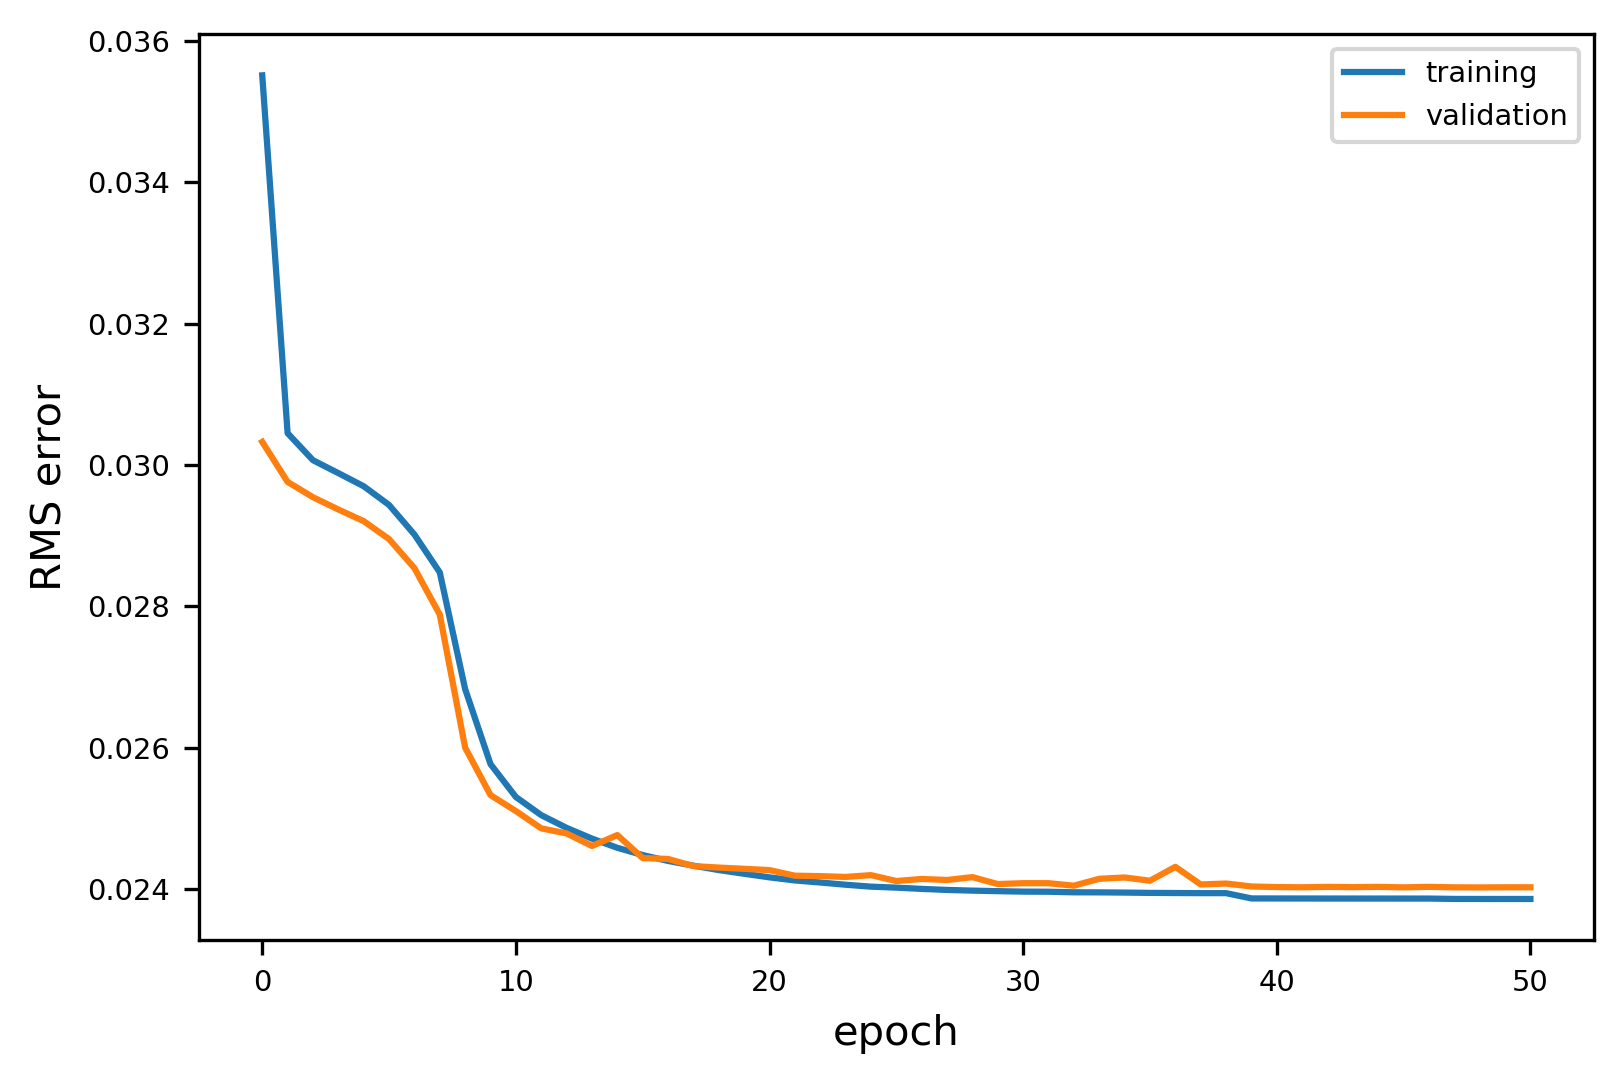

In [11]:
plt.plot(train_RMSE, label='training')
plt.plot(valid_RMSE, label='validation')
plt.ylabel('RMS error')
plt.xlabel('epoch')
plt.legend()
plt.show()

We can look at the results for the validation set by making a scatter plot of the predicted photometric redshift vs the true spectroscopic redshift and calculating the RMS error.

In [12]:
# even outside training, we need to tell PyTorch not to calculate gradients
with torch.no_grad():
    # unpack the validation data
    photometry = validdata[:][0]
    redshifts = validdata[:][1]
    # feed it into the trained model
    z_pred = model(photometry)

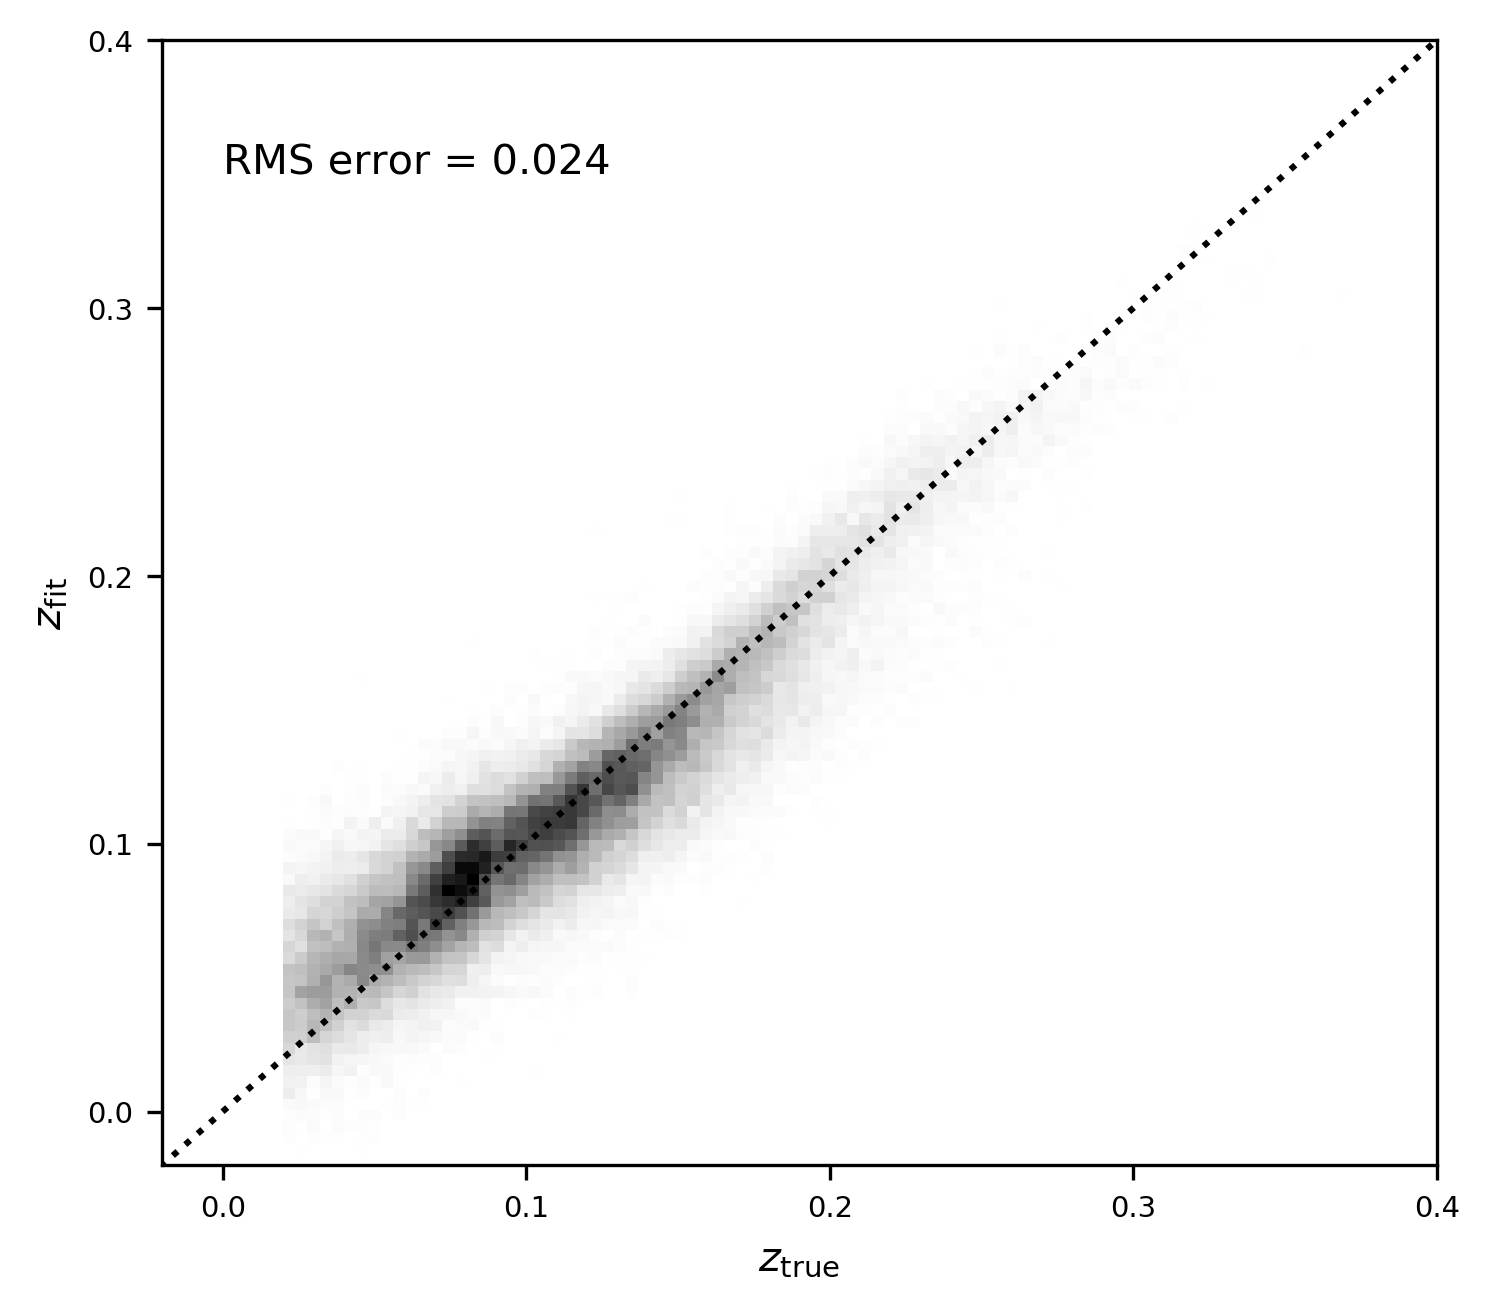

In [13]:
# make the scatter plot
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(wspace=0.25,
                    left=0.1, right=0.95,
                    bottom=0.15, top=0.9)

ax = plt.axes()
H, zs_bins, zp_bins = np.histogram2d(redshifts.numpy().flatten(), z_pred.numpy().flatten(), 151)
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
           extent=[zs_bins[0], zs_bins[-1], zp_bins[0], zp_bins[-1]],
           cmap=plt.cm.binary)
ax.plot([-0.1, 0.4], [-0.1, 0.4], ':k')
rms = np.sqrt(np.mean((z_pred-redshifts).numpy()**2))
ax.text(0, 0.35, 'RMS error = %0.3f' % np.sqrt(np.mean((z_pred-redshifts).numpy()**2)))
ax.set_xlim(-0.02, 0.4001)
ax.set_ylim(-0.02, 0.4001)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.set_xlabel(r'$z_{\rm true}$')
ax.set_ylabel(r'$z_{\rm fit}$')
plt.show()

## Things to try
1. Do a hyperparameter search using `trainmodel()`, varying the width of the hidden layer.
2. What happens when you make the learning rate much larger or smaller - how many epochs does the neural network train for, and how is its performance affected? Try changes by factors of 10x!